# PyTorch for CIFAR10
We test ResNet classifier.
First init some basic environment.

In [3]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

# resnet32 classifier

In [4]:
%%time
import torch.optim as optim
import torch.nn as nn
import sys
import copy
import numpy as np
import pandas as pd
import seaborn as sns
sys.path.append("cifar10/")

from cifar10.tnt_solver import *
from cifar10.classifiers.resnet import resnet32

torch.manual_seed(6666)
torch.cuda.manual_seed(6666)

model_orig = resnet32()
print(model_orig)

_ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): _BasicBlock(
      (conv_bn_relu1): Sequential(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (conv_bn2): Sequential(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu_out): ReLU(inplace=True)
    )
    (1): _BasicBlock(
      (conv_bn_relu1): Sequential(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=1e-05, mom

In [30]:
num_param = sum([len(param.flatten()) for param in model.parameters()])
num_param

466906

In [31]:
data = CIFAR10Data(train_split=0.8)
train_itr = data.get_train_loader(batch_size=64)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [32]:
def train_network(train_dl, val_dl, modelname, network, epochs, calc_every_x_epoch=10, device='cpu', pruned_weights=0, **kwargs):
    
    print('calc_every_x_epoch',calc_every_x_epoch)
        
    opt = optim.SGD(network.parameters(), lr=1e-1, momentum=0.9, weight_decay=1e-4, nesterov=False)
        
    loss_func = F.cross_entropy

    lr_scheduler= optim.lr_scheduler.MultiStepLR(opt, milestones=[91, 137], gamma=0.1)

#     history = main(model_orig, opt, epoch=5, model_name='ResNet20', pruned_weights=p_w, zero_masks=zero_masks, loss_fn=loss_fn, dev='cuda:1', lr_scheduler=lr_scheduler)

    training_information = pd.DataFrame({
                                    'modelname':[],
                                    'epoch':[],
                                    'loss_mb':[],
                                    'acc_mb':[],
                                    'loss':[],
                                    'acc':[],
#                                     'grad_norm_squared':[],
                                    'full_grad_norm':[],
                                    'pruned_weights':[]
                                    })

    
    opt.zero_grad()

    acc = 0
    loss = 0
    with torch.no_grad():
        for xb, yb in train_dl:
            xb = xb.to(device)
#             print(xb.device)
#             print(network.device)
            yb = yb.to(device)
            acc += accuracy(network(xb), yb)*len(yb)
            loss += loss_func(network(xb), yb)
        acc = acc/1000
        
    print('Epoch: 0 \t loss= %10.3e' %loss)
    
    print(p_w)
    if p_w > 0:
        zero_masks = []
        
        num_pos_param = sum([len(param[torch.abs(param)>0].flatten()) for param in network.parameters()])
        print(f'Num non-zero params before = {num_pos_param}')
        for param in network.parameters():

            param.requires_grad = False
            num_param = param.numel()

            num_zero_out = int(p_w*num_param)
            param_flt = param.flatten()

            shp = param.shape


            zeroed_indices = torch.topk(torch.abs(param_flt),num_zero_out, largest=False).indices

            indices = np.unravel_index(zeroed_indices.detach().cpu(), shp, order='C')

            zero_mask = torch.ones(shp, device=device)
            
            zero_mask[indices]=0
            zero_masks.append(zero_mask)

            param_flt[zeroed_indices] = 0

            param = param_flt.reshape(shp)
        
        num_pos_param = sum([len(param[torch.abs(param)>0].flatten()) for param in network.parameters()])
        print(f'Num non-zero params after = {num_pos_param}')

        for param in network.parameters():
            param.requires_grad = True

    for epoch in tqdm(range(epochs)):
        
        if epoch%calc_every_x_epoch==0:
            
            print('saving model')
            # print(network.lin_in.weight)
            filename = ('%s_' + 'pruned_weights=%.1f' + '_epoch=%d' + '.pt') % (modelname, pruned_weights, epoch)
            
            torch.save(network, filename)
        
        
        for xb, yb in train_dl:
            xb= xb.to(device)
            yb= yb.to(device)
            pred = network(xb)       
            
            loss_mb = loss_func(pred, yb)
            
#             loss.requires_grad_()

            loss_mb.backward()
            
            if pruned_weights > 0:
                # Apply the mask to gradients
                zz = 0
                for param in network.parameters():
                    
                    param.grad *= zero_masks[zz]
                    zz += 1
#                 print(sum([len(param[torch.abs(param.grad)>0].flatten()) for param in network.parameters()]))

                        
            grad_vec = []
            for param in network.parameters():
                grad_vec = np.append(grad_vec,torch.flatten(param.grad.detach().cpu()))
            
            acc_mb = accuracy(network(xb), yb).cpu()
            loss_mb = loss_func(network(xb), yb).cpu()
            
                    
            training_information.loc[len(training_information)] = [modelname, epoch, loss_mb.detach().numpy(), acc_mb.detach().numpy(), loss.detach().cpu().numpy(),
acc.detach().cpu().numpy(), np.linalg.norm(grad_vec), pruned_weights]
            
            
            opt.step()
            opt.zero_grad()
            
        acc = 0
        loss = 0
        with torch.no_grad():
            for xb, yb in train_dl:
                xb= xb.to(device)
                yb= yb.to(device)
                acc += accuracy(network(xb), yb)*len(yb)
                loss += loss_func(network(xb), yb)
            acc = acc/1000

        lr_scheduler.step()
        
        
        
        if epoch%int(epochs/10 + 1) ==0:
            print('Epoch: %d \t loss= %10.4e \t acc= %10.4e' %(epoch+1, loss, acc))
                

    print('Epoch: %d \t loss= %10.4e \t acc= %.2f' %(epoch+1, loss, acc))


    # print(network.lin_in.weight)
    filename = ('%s_' + 'pruned_weights=%.1f' + '_epoch=%d' + '.pt') % (modelname, pruned_weights, epoch)
    # model_scripted.save(filename)
    torch.save(network, filename)

    return training_information

In [33]:
def accuracy(out, yb):
    '''
    calculates the accurac based on the predicted outputs and true labels y

    out: predicted output
    yb: true labels y
    '''
    
#     print(out.shape, yb.shape)
    preds = torch.argmax(out, axis=1)
#     print(preds.shape, yb.shape)
#     yb = torch.argmax(yb, axis=1)
    
#     print(preds[0:5], yb[0:5])
    return (preds == yb).float().mean()


In [34]:

device='cuda:1'

pruned_weights = [0.8,0.6,0.4,0.2,0.0] 


for p_w in pruned_weights:
    
    model_orig = model_orig.to(device)
    
    model = copy.deepcopy(model_orig)
        
    print(p_w)
    if p_w > 0:
        zero_masks = []
        
        num_pos_param = sum([len(param[torch.abs(param)>0].flatten()) for param in model.parameters()])
        print(f'Num non-zero params before = {num_pos_param}')
        for param in model.parameters():

            param.requires_grad = False
            num_param = param.numel()

            num_zero_out = int(p_w*num_param)
            param_flt = param.flatten()

            shp = param.shape

#             print(f"#param={num_param}, pruned_weight={p_w*100}%, #zero out={num_zero_out}") 

            zeroed_indices = torch.topk(torch.abs(param_flt),num_zero_out, largest=False).indices

            indices = np.unravel_index(zeroed_indices.detach().cpu(), shp, order='C')

            zero_mask = torch.ones(shp, device=device)
            zero_mask[indices]=0
            zero_masks.append(zero_mask)

            param_flt[zeroed_indices] = 0

            param = param_flt.reshape(shp)
        
        num_pos_param = sum([len(param[torch.abs(param)>0].flatten()) for param in model.parameters()])
        print(f'Num non-zero params after = {num_pos_param}')

        for param in model.parameters():
            param.requires_grad = True
            
    train_info = train_network(train_itr, train_itr, 'ResNet32', model, 100, calc_every_x_epoch=20, device=device, pruned_weights=p_w)

    train_info.to_pickle(f"training_information_ResNet32_pruned_weights={p_w}.pkl")    

0.8
Num non-zero params before = 465674
Num non-zero params after = 93166
calc_every_x_epoch 20
Epoch: 0 	 loss=  3.711e+01
0.8
Num non-zero params before = 93166
Num non-zero params after = 93166


  0%|                                                                                                                                                                                         | 0/100 [00:00<?, ?it/s]

saving model


  1%|█▊                                                                                                                                                                               | 1/100 [00:02<03:38,  2.20s/it]

Epoch: 1 	 loss= 3.6607e+01 	 acc= 1.8600e-01


 12%|█████████████████████                                                                                                                                                           | 12/100 [00:26<03:11,  2.18s/it]

Epoch: 12 	 loss= 2.9221e+01 	 acc= 3.2700e-01


 20%|███████████████████████████████████▏                                                                                                                                            | 20/100 [00:43<02:49,  2.12s/it]

saving model


 23%|████████████████████████████████████████▍                                                                                                                                       | 23/100 [00:49<02:42,  2.11s/it]

Epoch: 23 	 loss= 2.8591e+01 	 acc= 3.1300e-01


 34%|███████████████████████████████████████████████████████████▊                                                                                                                    | 34/100 [01:13<02:23,  2.17s/it]

Epoch: 34 	 loss= 2.6253e+01 	 acc= 3.9300e-01


 40%|██████████████████████████████████████████████████████████████████████▍                                                                                                         | 40/100 [01:26<02:09,  2.16s/it]

saving model


 45%|███████████████████████████████████████████████████████████████████████████████▏                                                                                                | 45/100 [01:37<01:54,  2.09s/it]

Epoch: 45 	 loss= 2.5298e+01 	 acc= 4.0700e-01


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 56/100 [02:00<01:37,  2.21s/it]

Epoch: 56 	 loss= 2.5082e+01 	 acc= 4.0900e-01


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 60/100 [02:09<01:26,  2.17s/it]

saving model


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 67/100 [02:24<01:11,  2.16s/it]

Epoch: 67 	 loss= 2.3478e+01 	 acc= 4.6600e-01


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 78/100 [02:48<00:47,  2.15s/it]

Epoch: 78 	 loss= 2.2415e+01 	 acc= 4.7000e-01


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 80/100 [02:52<00:42,  2.11s/it]

saving model


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 89/100 [03:11<00:24,  2.19s/it]

Epoch: 89 	 loss= 2.1368e+01 	 acc= 4.8000e-01


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [03:35<00:00,  2.15s/it]

Epoch: 100 	 loss= 1.9200e+01 	 acc= 5.4600e-01
Epoch: 100 	 loss= 1.9200e+01 	 acc= 0.55
0.6
Num non-zero params before = 465674
Num non-zero params after = 186298
calc_every_x_epoch 20


Epoch: 0 	 loss=  3.778e+01
0.6
Num non-zero params before = 186298
Num non-zero params after = 186298


  0%|                                                                                                                                                                                         | 0/100 [00:00<?, ?it/s]

saving model


  1%|█▊                                                                                                                                                                               | 1/100 [00:01<03:15,  1.97s/it]

Epoch: 1 	 loss= 3.4213e+01 	 acc= 1.7500e-01


 12%|█████████████████████                                                                                                                                                           | 12/100 [00:25<03:15,  2.22s/it]

Epoch: 12 	 loss= 2.7315e+01 	 acc= 3.2900e-01


 20%|███████████████████████████████████▏                                                                                                                                            | 20/100 [00:42<02:49,  2.12s/it]

saving model


 23%|████████████████████████████████████████▍                                                                                                                                       | 23/100 [00:49<02:43,  2.12s/it]

Epoch: 23 	 loss= 2.3510e+01 	 acc= 4.5000e-01


 34%|███████████████████████████████████████████████████████████▊                                                                                                                    | 34/100 [01:12<02:20,  2.13s/it]

Epoch: 34 	 loss= 2.0866e+01 	 acc= 5.3100e-01


 40%|██████████████████████████████████████████████████████████████████████▍                                                                                                         | 40/100 [01:25<02:10,  2.18s/it]

saving model


 45%|███████████████████████████████████████████████████████████████████████████████▏                                                                                                | 45/100 [01:36<02:00,  2.19s/it]

Epoch: 45 	 loss= 1.9425e+01 	 acc= 5.6400e-01


Connection is already closed.
Connection is already closed.
Connection is already closed.
Connection is already closed.
Connection is already closed.
Connection is already closed.
Connection is already closed.
Connection is already closed.
Connection is already closed.
Connection is already closed.
Connection is already closed.
Connection is already closed.
 47%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                             | 47/100 [01:40<01:55,  2.17s/it][Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
 48%|█████████████████████████████████████████████████

Epoch: 56 	 loss= 1.6559e+01 	 acc= 6.2700e-01


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 60/100 [02:08<01:25,  2.15s/it]

saving model


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 67/100 [02:23<01:08,  2.09s/it]

Epoch: 67 	 loss= 1.6596e+01 	 acc= 6.3000e-01


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 78/100 [02:47<00:48,  2.20s/it]

Epoch: 78 	 loss= 1.4240e+01 	 acc= 6.5500e-01


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 80/100 [02:51<00:44,  2.21s/it]

saving model


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 89/100 [03:10<00:23,  2.10s/it]

Epoch: 89 	 loss= 1.2025e+01 	 acc= 7.3100e-01


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [03:33<00:00,  2.14s/it]

Epoch: 100 	 loss= 7.1467e+00 	 acc= 8.5800e-01
Epoch: 100 	 loss= 7.1467e+00 	 acc= 0.86
0.4
Num non-zero params before = 465674
Num non-zero params after = 279442
calc_every_x_epoch 20


Epoch: 0 	 loss=  3.800e+01
0.4
Num non-zero params before = 279442
Num non-zero params after = 279442


  0%|                                                                                                                                                                                         | 0/100 [00:00<?, ?it/s]

saving model


  1%|█▊                                                                                                                                                                               | 1/100 [00:01<03:09,  1.92s/it]

Epoch: 1 	 loss= 3.5280e+01 	 acc= 1.7400e-01


 12%|█████████████████████                                                                                                                                                           | 12/100 [00:25<03:06,  2.12s/it]

Epoch: 12 	 loss= 2.7952e+01 	 acc= 3.2000e-01


 20%|███████████████████████████████████▏                                                                                                                                            | 20/100 [00:42<02:50,  2.13s/it]

saving model


 23%|████████████████████████████████████████▍                                                                                                                                       | 23/100 [00:48<02:41,  2.10s/it]

Epoch: 23 	 loss= 2.4468e+01 	 acc= 4.4000e-01


 34%|███████████████████████████████████████████████████████████▊                                                                                                                    | 34/100 [01:12<02:25,  2.21s/it]

Epoch: 34 	 loss= 2.1620e+01 	 acc= 5.0500e-01


 40%|██████████████████████████████████████████████████████████████████████▍                                                                                                         | 40/100 [01:25<02:07,  2.13s/it]

saving model


 45%|███████████████████████████████████████████████████████████████████████████████▏                                                                                                | 45/100 [01:36<01:59,  2.18s/it]

Epoch: 45 	 loss= 1.7520e+01 	 acc= 6.1100e-01


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 56/100 [02:01<01:46,  2.42s/it]

Epoch: 56 	 loss= 1.5368e+01 	 acc= 6.5400e-01


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 60/100 [02:10<01:27,  2.19s/it]

saving model


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 67/100 [02:25<01:10,  2.15s/it]

Epoch: 67 	 loss= 1.3256e+01 	 acc= 6.9200e-01


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 78/100 [02:48<00:45,  2.08s/it]

Epoch: 78 	 loss= 1.0685e+01 	 acc= 7.8200e-01


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 80/100 [02:52<00:40,  2.04s/it]

saving model


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 89/100 [03:11<00:23,  2.12s/it]

Epoch: 89 	 loss= 8.8202e+00 	 acc= 8.1600e-01


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [03:35<00:00,  2.16s/it]

Epoch: 100 	 loss= 3.2273e+00 	 acc= 9.4000e-01
Epoch: 100 	 loss= 3.2273e+00 	 acc= 0.94
0.2
Num non-zero params before = 465674
Num non-zero params after = 372574
calc_every_x_epoch 20


Epoch: 0 	 loss=  3.987e+01
0.2
Num non-zero params before = 372574
Num non-zero params after = 372574


  0%|                                                                                                                                                                                         | 0/100 [00:00<?, ?it/s]

saving model


  1%|█▊                                                                                                                                                                               | 1/100 [00:02<03:30,  2.13s/it]

Epoch: 1 	 loss= 3.7117e+01 	 acc= 1.3200e-01


 12%|█████████████████████                                                                                                                                                           | 12/100 [00:25<03:09,  2.15s/it]

Epoch: 12 	 loss= 2.9594e+01 	 acc= 2.9500e-01


 20%|███████████████████████████████████▏                                                                                                                                            | 20/100 [00:42<02:49,  2.12s/it]

saving model


 23%|████████████████████████████████████████▍                                                                                                                                       | 23/100 [00:48<02:44,  2.14s/it]

Epoch: 23 	 loss= 2.5495e+01 	 acc= 4.4400e-01


 34%|███████████████████████████████████████████████████████████▊                                                                                                                    | 34/100 [01:11<02:20,  2.12s/it]

Epoch: 34 	 loss= 2.1573e+01 	 acc= 5.1500e-01


 40%|██████████████████████████████████████████████████████████████████████▍                                                                                                         | 40/100 [01:24<02:06,  2.11s/it]

saving model


 45%|███████████████████████████████████████████████████████████████████████████████▏                                                                                                | 45/100 [01:35<02:00,  2.19s/it]

Epoch: 45 	 loss= 1.8477e+01 	 acc= 5.7600e-01


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 56/100 [01:58<01:32,  2.09s/it]

Epoch: 56 	 loss= 1.4796e+01 	 acc= 6.6200e-01


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 60/100 [02:07<01:25,  2.14s/it]

saving model


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 67/100 [02:22<01:10,  2.13s/it]

Epoch: 67 	 loss= 1.2266e+01 	 acc= 7.3800e-01


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 78/100 [02:45<00:46,  2.13s/it]

Epoch: 78 	 loss= 8.4323e+00 	 acc= 8.2200e-01


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 80/100 [02:50<00:42,  2.13s/it]

saving model


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 89/100 [03:09<00:24,  2.20s/it]

Epoch: 89 	 loss= 6.3517e+00 	 acc= 8.5000e-01


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [03:33<00:00,  2.14s/it]

Epoch: 100 	 loss= 2.1171e+00 	 acc= 9.6700e-01
Epoch: 100 	 loss= 2.1171e+00 	 acc= 0.97
0.0
calc_every_x_epoch 20


Epoch: 0 	 loss=  4.119e+01
0.0


  0%|                                                                                                                                                                                         | 0/100 [00:00<?, ?it/s]

saving model


  1%|█▊                                                                                                                                                                               | 1/100 [00:02<03:24,  2.06s/it]

Epoch: 1 	 loss= 3.7712e+01 	 acc= 1.6800e-01


 12%|█████████████████████                                                                                                                                                           | 12/100 [00:26<03:22,  2.30s/it]

Epoch: 12 	 loss= 2.8510e+01 	 acc= 3.4100e-01


 20%|███████████████████████████████████▏                                                                                                                                            | 20/100 [00:44<02:51,  2.15s/it]

saving model


 23%|████████████████████████████████████████▍                                                                                                                                       | 23/100 [00:50<02:45,  2.15s/it]

Epoch: 23 	 loss= 2.3639e+01 	 acc= 4.6300e-01


 34%|███████████████████████████████████████████████████████████▊                                                                                                                    | 34/100 [01:14<02:25,  2.20s/it]

Epoch: 34 	 loss= 1.9545e+01 	 acc= 5.9100e-01


 40%|██████████████████████████████████████████████████████████████████████▍                                                                                                         | 40/100 [01:27<02:09,  2.15s/it]

saving model


 45%|███████████████████████████████████████████████████████████████████████████████▏                                                                                                | 45/100 [01:38<02:00,  2.20s/it]

Epoch: 45 	 loss= 1.6222e+01 	 acc= 6.2700e-01


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 56/100 [02:02<01:33,  2.12s/it]

Epoch: 56 	 loss= 1.1529e+01 	 acc= 7.4400e-01


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 60/100 [02:10<01:26,  2.16s/it]

saving model


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 67/100 [02:25<01:08,  2.06s/it]

Epoch: 67 	 loss= 1.0287e+01 	 acc= 7.7100e-01


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 78/100 [02:48<00:46,  2.13s/it]

Epoch: 78 	 loss= 7.0288e+00 	 acc= 8.5400e-01


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 80/100 [02:52<00:43,  2.17s/it]

saving model


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 89/100 [03:12<00:24,  2.19s/it]

Epoch: 89 	 loss= 5.7660e+00 	 acc= 8.6800e-01


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [03:35<00:00,  2.15s/it]

Epoch: 100 	 loss= 1.1614e+00 	 acc= 9.9000e-01
Epoch: 100 	 loss= 1.1614e+00 	 acc= 0.99


In [5]:
def load_pandas_df(file_name):
    df = pd.read_pickle(file_name)
    
    return df    

In [6]:

pruned_weights = [0.0, 0.2, 0.4, 0.6, 0.8]

training_infos = []
for p_w in pruned_weights:
    fn = f'training_information_ResNet32_pruned_weights={p_w}.pkl'
    df = load_pandas_df(fn)
    df = df.astype({'loss':float, 'acc':float, 'loss_mb':float, 'acc_mb':float})
    training_infos.append(df)
    


In [7]:
pd.concat(training_infos)

,modelname,epoch,loss_mb,acc_mb,loss,acc,full_grad_norm,pruned_weights
0,ResNet32,0,2.522794,0.078125,41.187256,0.088,6.879318,0.0
1,ResNet32,0,2.375124,0.171875,41.187256,0.088,6.436945,0.0
2,ResNet32,0,2.604136,0.078125,41.187256,0.088,6.472061,0.0
3,ResNet32,0,2.532304,0.156250,41.187256,0.088,6.053850,0.0
4,ResNet32,0,2.908307,0.093750,41.187256,0.088,5.723793,0.0
...,...,...,...,...,...,...,...,...
1595,ResNet32,99,1.206048,0.515625,19.586666,0.547,0.944916,0.8
1596,ResNet32,99,1.091857,0.546875,19.586666,0.547,0.763724,0.8
1597,ResNet32,99,1.160569,0.562500,19.586666,0.547,0.992754,0.8
1598,ResNet32,99,1.280861,0.562500,19.586666,0.547,0.867845,0.8


/users/staff/dmi-dmi/zhao0005/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


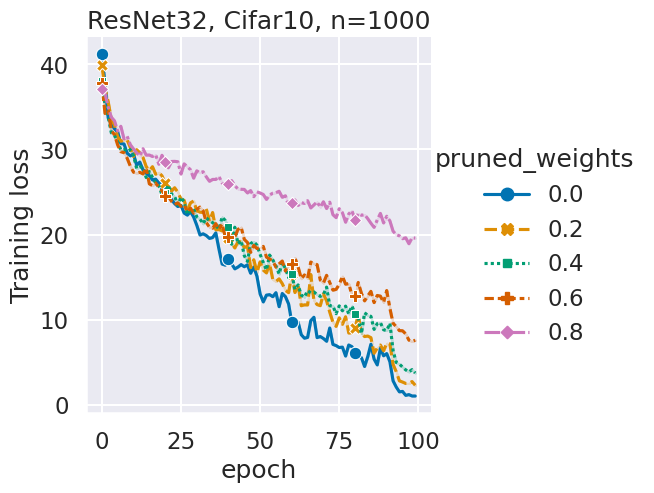

In [142]:
import seaborn as sns

sns.set_theme()
sns.set_context("talk")

def plot_hessian_info(df,y):
    
    sns.relplot(df, x='epoch', y=y, hue='pruned_weights', style='pruned_weights', markers=True, kind='line', palette='colorblind')
   

sns.relplot(pd.concat(training_infos), x='epoch', y='loss', hue='pruned_weights', style='pruned_weights', markers=True, markevery=20, kind='line', palette='colorblind')

plt.title('ResNet32, Cifar10, n=1000')
plt.ylabel('Training loss')

plt.savefig('training_loss_ResNet32_pruned_weights.pdf', bbox_inches='tight')

In [119]:
training_infos_resnet32 = pd.concat(training_infos)

training_infos_resnet32.to_pickle(f"panda_dataframes/training_information_ResNet32_pruned_weights.pkl")

In [86]:
pruned_weights = [0.0, 0.2, 0.4, 0.6]
epoch = 99

dfs = []
for p_w in pruned_weights:
    fn = f'panda_dataframes/outer_prod_hessian_information_ResNet32_pruned_weights={p_w}_{epoch}.pkl'

    df = load_pandas_df(fn)

    df = df.astype({'H_o_cond': float, 'H_o_rank': int, 'lambda_max_H_o': float, 'lambda_min_H_o': float})

    dfs.append(df)

hession_info_resnet32 = pd.concat(dfs,ignore_index=True)

In [41]:
pruned_weights = [0.8]
epochs = [0,20,40,60,80,99]

dfs = []
for epoch in epochs:
    for p_w in pruned_weights:
        fn = f'panda_dataframes/outer_prod_hessian_information_ResNet32_pruned_weights={p_w}_{epoch}.pkl'

        df = load_pandas_df(fn)

        df = df.astype({'H_o_cond': float, 'H_o_rank': int, 'lambda_max_H_o': float, 'lambda_min_H_o': float})

        dfs.append(df)
    
hession_info_resnet32_p_w_08 = pd.concat(dfs,ignore_index=True)
    


In [49]:
for i in range(len(hession_info_resnet32_p_w_08)):
    print(i)
    spec = hession_info_resnet32_p_w_08.loc[i].H_o_spectrum
    spec[spec < 0] = 0
    
    rank = torch.linalg.matrix_rank(torch.diag(spec), atol=1e-7)
    
    hession_info_resnet32_p_w_08.H_o_rank.loc[i] = int(rank)
    hession_info_resnet32_p_w_08.lambda_min_H_o.loc[i] = float(spec[-rank])
    
    hession_info_resnet32_p_w_08.H_o_cond.loc[i] = hession_info_resnet32_p_w_08.loc[i].lambda_max_H_o/float(spec[-rank])

0


/tmp/ipykernel_3819595/4097136499.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hession_info_resnet32_p_w_08.H_o_rank.loc[i] = int(rank)
/tmp/ipykernel_3819595/4097136499.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hession_info_resnet32_p_w_08.lambda_min_H_o.loc[i] = float(spec[-rank])
/tmp/ipykernel_3819595/4097136499.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hession_info_resnet32_p_w_08.H_o_cond.loc[i] = hess

1


/tmp/ipykernel_3819595/4097136499.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hession_info_resnet32_p_w_08.H_o_rank.loc[i] = int(rank)
/tmp/ipykernel_3819595/4097136499.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hession_info_resnet32_p_w_08.lambda_min_H_o.loc[i] = float(spec[-rank])
/tmp/ipykernel_3819595/4097136499.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hession_info_resnet32_p_w_08.H_o_cond.loc[i] = hess

2


/tmp/ipykernel_3819595/4097136499.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hession_info_resnet32_p_w_08.H_o_rank.loc[i] = int(rank)
/tmp/ipykernel_3819595/4097136499.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hession_info_resnet32_p_w_08.lambda_min_H_o.loc[i] = float(spec[-rank])
/tmp/ipykernel_3819595/4097136499.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hession_info_resnet32_p_w_08.H_o_cond.loc[i] = hess

3


/tmp/ipykernel_3819595/4097136499.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hession_info_resnet32_p_w_08.H_o_rank.loc[i] = int(rank)
/tmp/ipykernel_3819595/4097136499.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hession_info_resnet32_p_w_08.lambda_min_H_o.loc[i] = float(spec[-rank])
/tmp/ipykernel_3819595/4097136499.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hession_info_resnet32_p_w_08.H_o_cond.loc[i] = hess

4


/tmp/ipykernel_3819595/4097136499.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hession_info_resnet32_p_w_08.H_o_rank.loc[i] = int(rank)
/tmp/ipykernel_3819595/4097136499.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hession_info_resnet32_p_w_08.lambda_min_H_o.loc[i] = float(spec[-rank])
/tmp/ipykernel_3819595/4097136499.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hession_info_resnet32_p_w_08.H_o_cond.loc[i] = hess

5


/tmp/ipykernel_3819595/4097136499.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hession_info_resnet32_p_w_08.H_o_rank.loc[i] = int(rank)
/tmp/ipykernel_3819595/4097136499.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hession_info_resnet32_p_w_08.lambda_min_H_o.loc[i] = float(spec[-rank])
/tmp/ipykernel_3819595/4097136499.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hession_info_resnet32_p_w_08.H_o_cond.loc[i] = hess

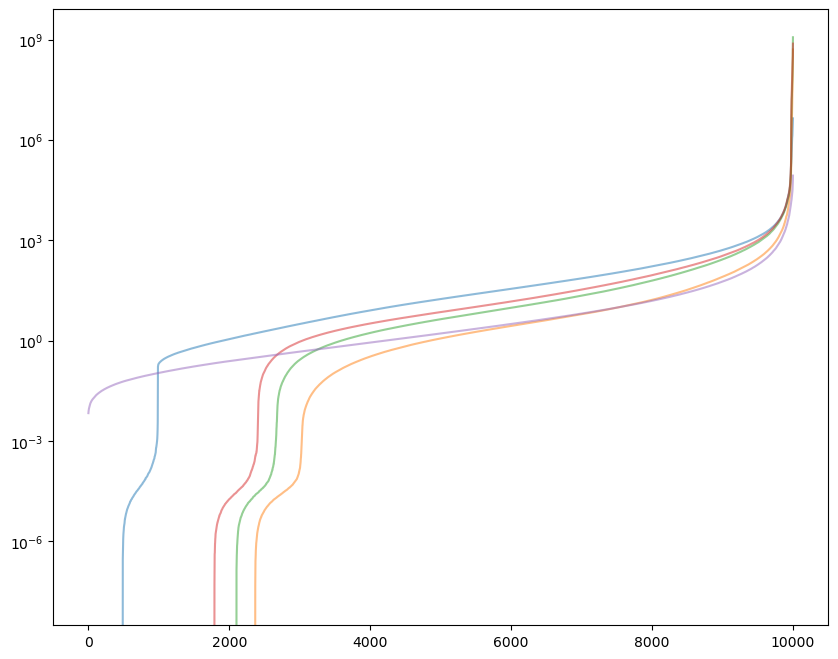

In [65]:
plt.semilogy(hession_info_resnet32_p_w_08.H_o_spectrum.iloc[0],alpha=0.5)
plt.semilogy(hession_info_resnet32_p_w_08.H_o_spectrum.iloc[1],alpha=0.5)
plt.semilogy(hession_info_resnet32_p_w_08.H_o_spectrum.iloc[2],alpha=0.5)
plt.semilogy(hession_info_resnet32_p_w_08.H_o_spectrum.iloc[3],alpha=0.5)


plt.semilogy(hession_info_resnet32.H_o_spectrum.iloc[13],alpha=0.5)

In [87]:
hession_info_resnet32 = pd.concat([hession_info_resnet32,hession_info_resnet32_p_w_08],ignore_index=True)
hession_info_resnet32

,dataset,num_samples,network,pruned_weights,epoch,H_o_cond,H_o_spectrum,H_o_rank,lambda_max_H_o,lambda_min_H_o
0,Cifar10,1000,ResNet32,0.0,0,9.578475e+03,"[tensor(94.8110), tensor(95.9079), tensor(96.6...",10000,9.081451e+05,9.481104e+01
1,Cifar10,1000,ResNet32,0.0,20,5.092344e+06,"[tensor(0.0106), tensor(0.0115), tensor(0.0120...",10000,5.421620e+04,1.064661e-02
2,Cifar10,1000,ResNet32,0.0,40,1.269568e+06,"[tensor(0.0447), tensor(0.0468), tensor(0.0472...",10000,5.680521e+04,4.474375e-02
3,Cifar10,1000,ResNet32,0.0,60,1.074148e+06,"[tensor(0.0710), tensor(0.0762), tensor(0.0783...",10000,7.623944e+04,7.097663e-02
4,Cifar10,1000,ResNet32,0.0,80,1.381855e+06,"[tensor(0.0655), tensor(0.0667), tensor(0.0681...",10000,9.053786e+04,6.551908e-02
5,Cifar10,1000,ResNet32,0.0,99,8.298274e+05,"[tensor(0.0854), tensor(0.0912), tensor(0.0952...",10000,7.086727e+04,8.540001e-02
6,Cifar10,1000,ResNet32,0.2,0,1.497921e+04,"[tensor(42.0913), tensor(42.7606), tensor(43.3...",10000,6.304946e+05,4.209131e+01
7,Cifar10,1000,ResNet32,0.2,20,1.835480e+07,"[tensor(0.0044), tensor(0.0053), tensor(0.0057...",10000,8.028517e+04,4.374069e-03
8,Cifar10,1000,ResNet32,0.2,40,2.706249e+05,"[tensor(0.1649), tensor(0.1692), tensor(0.1703...",10000,4.463775e+04,1.649432e-01
9,Cifar10,1000,ResNet32,0.2,60,1.929393e+05,"[tensor(0.3856), tensor(0.3956), tensor(0.4203...",10000,7.440042e+04,3.856157e-01


In [118]:
hession_info_resnet32.to_pickle(f"panda_dataframes/outer_prod_hessian_information_ResNet32_pruned_weights.pkl")

In [132]:
spec = hession_info_resnet32.loc[4].H_o_spectrum
spec[spec < 0] = 0

rank = torch.linalg.matrix_rank(torch.diag(spec), rtol=1e-5)

In [133]:
rank

tensor(9122)

In [134]:
spec[-1]/spec[-rank]

tensor(99921.8125)

In [135]:
spec = hession_info_resnet32.loc[19].H_o_spectrum
spec[spec < 0] = 0

rank = torch.linalg.matrix_rank(torch.diag(spec), rtol=1e-5)

In [136]:
spec[-1]/spec[-rank]

tensor(99916.6328)

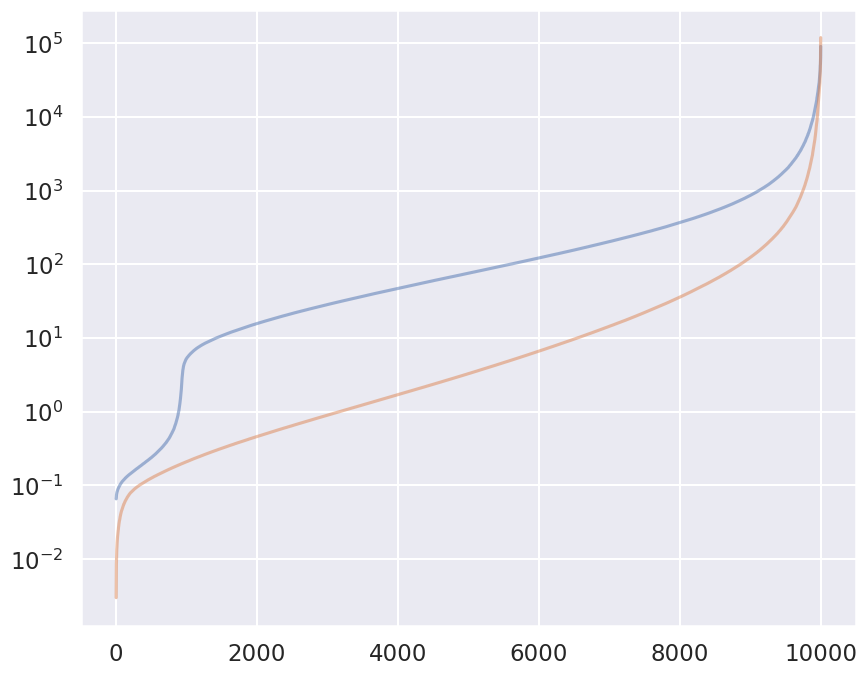

In [88]:
plt.semilogy(hession_info_resnet32.H_o_spectrum.iloc[4],alpha=0.5)
plt.semilogy(hession_info_resnet32.H_o_spectrum.iloc[19],alpha=0.5)

/users/staff/dmi-dmi/zhao0005/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


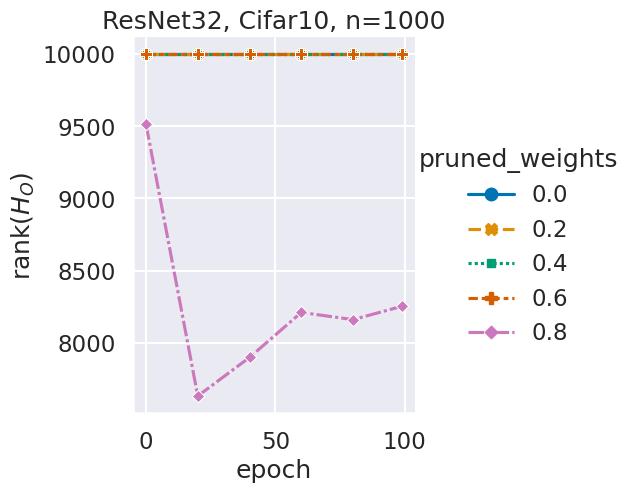

In [137]:
sns.relplot(hession_info_resnet32, x='epoch', y='H_o_rank', hue='pruned_weights', style='pruned_weights', markers=True, kind='line', palette='colorblind')

plt.ylabel('rank$(H_O)$')

plt.title('ResNet32, Cifar10, n=1000')
plt.savefig('ResNet32_rank_HO.pdf', bbox_inches='tight')

/users/staff/dmi-dmi/zhao0005/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


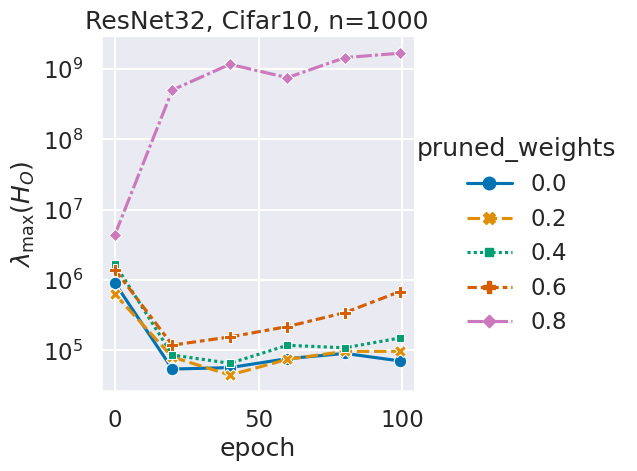

In [138]:
sns.relplot(hession_info_resnet32, x='epoch', y='lambda_max_H_o', hue='pruned_weights', style='pruned_weights', markers=True, kind='line', palette='colorblind')
plt.yscale('log')


plt.ylabel('$\lambda_{\max}(H_O)$')

plt.title('ResNet32, Cifar10, n=1000')
plt.savefig('ResNet32_lam_max_HO.pdf', bbox_inches='tight')

/users/staff/dmi-dmi/zhao0005/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


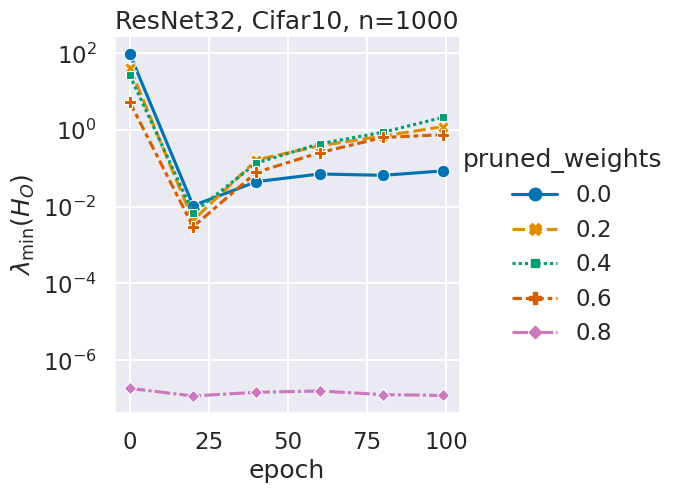

In [139]:
sns.relplot(hession_info_resnet32, x='epoch', y='lambda_min_H_o', hue='pruned_weights', style='pruned_weights', markers=True, kind='line', palette='colorblind')

plt.yscale('log')

plt.ylabel('$\lambda_{\min}(H_O)$')

plt.title('ResNet32, Cifar10, n=1000')
plt.savefig('ResNet32_lam_min_HO.pdf', bbox_inches='tight')

/users/staff/dmi-dmi/zhao0005/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


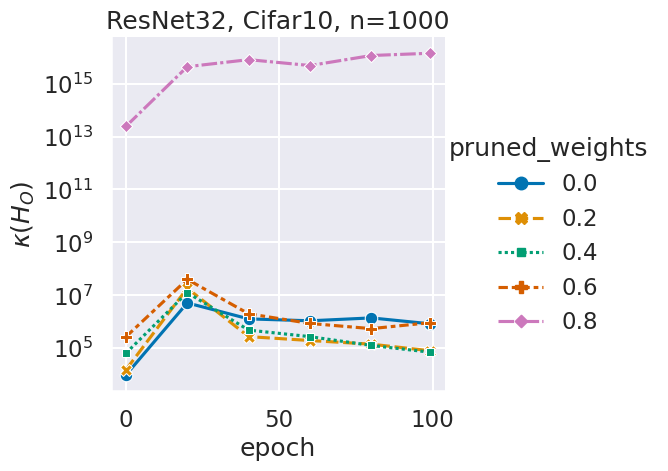

In [140]:
sns.relplot(hession_info_resnet32, x='epoch', y='H_o_cond', hue='pruned_weights', style='pruned_weights', markers=True, kind='line', palette='colorblind')

plt.yscale('log')

plt.ylabel('$\kappa(H_O)$')

plt.title('ResNet32, Cifar10, n=1000')
plt.savefig('ResNet32_cond_HO.pdf', bbox_inches='tight')

In [112]:
np.log(sum((hession_info_resnet32[hession_info_resnet32['pruned_weights'] == 0.0].H_o_cond)))

16.0832267711864

In [113]:
np.log(sum((hession_info_resnet32[hession_info_resnet32['pruned_weights'] == 0.2].H_o_cond)))

16.762730678966136

In [114]:
np.log(sum((hession_info_resnet32[hession_info_resnet32['pruned_weights'] == 0.4].H_o_cond)))

16.421535636889278

In [115]:
np.log(sum((hession_info_resnet32[hession_info_resnet32['pruned_weights'] == 0.6].H_o_cond)))

17.606385478710195

In [116]:
np.log(sum((hession_info_resnet32[hession_info_resnet32['pruned_weights'] == 0.8].H_o_cond)))

38.30023469337831

### train reset32


In [9]:
%%time
opt = optim.SGD(model.parameters(), lr=1e-1, momentum=0.9, weight_decay=1e-4, nesterov=False)
loss_fn = F.cross_entropy

lr_scheduler= optim.lr_scheduler.MultiStepLR(opt, milestones=[91, 137], gamma=0.1)
history = main(model, opt, epoch=100, loss_fn=loss_fn, model_name='resnet32', pruned_weights=0.0, lr_scheduler=lr_scheduler)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


Setting up a new session...
Setting up a new session...


Setting up a new session...
Setting up a new session...
Setting up a new session...
Setting up a new session...


Epoch: 1/100, lr:1.00e-01
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.76it/s, loss:2.2180, acc:17.0000%]
Val loss: 4.6343, accuracy: 14.00%
Epoch: 2/100, lr:1.00e-01
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:03<00:00,  5.09it/s, loss:2.1867, acc:19.1000%]
Val loss: 2.3544, accuracy: 13.60%
Epoch: 3/100, lr:1.00e-01
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:03<00:00,  5.12it/s, loss:2.0710, acc:20.5000%]
Val loss: 2.1142, accuracy: 18.40%
Epoch: 4/100, lr:1.00e-01
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:03<00:00,  5.25it/s, loss:0.7830, acc:71.9000%]
Val loss: 2.4650, accuracy: 40.80%
Epoch: 60/100, lr:1.00e-01
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.43it/s, loss:0.7992, acc:70.9000%]
Val loss: 2.2231, accuracy: 43.60%
Epoch: 61/100, lr:1.00e-01
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.50it/s, loss:0.8089, acc:71.3000%]
Val loss: 2.2851, accuracy: 41.20%
Epoch: 62/100, lr:1.00e-01
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02

# plot loss history
We check the classifier by plotting the loss and acc.

In [4]:
plot_history(history)

NameError: name 'history' is not defined